# Second approach: Dimensionality reduction using PCA

In this second approach, we will use PCA to reduce the dimensionality of the dataset. For this case, we will train the same models as in the first approach, but using the reduced dataset obtained by PCA.

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


**Index**

- [Data loading](#Data-loading)
- [PCA Transformation](#PCA-Transformation)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
  - [Base model plots](#Base-model-plots)
- [Ensemble models](#Ensemble-models)
  - [Training](#Training)
  - [Ensemble model plots](#Ensemble-model-plots)


## Data loading

In this second approach, we will preprocess ths data by applying PCA to reduce the dimensionality of the dataset. The number of components will be chosen by the explained variance ratio. First, we will perform the data loading and the PCA transformation to all the data in order to analize the results and choose the number of components.

Then, to evaluate the models, we will use a **5-fold cross-validation** instead of splitting the data into training and test sets. By doing this, we will be able to compare the models in a more robust way and reduce the dependence on the randomness of the data split. So, the data passed to the training function will be the whole dataset before the PCA transformation. In this way, the PCA transformation will be applied in each fold of the cross-validation, avoiding data leakage.

Regarding to the metrics used to evaluate the models, we will use the **accuracy**, **precision**, **recall** and **f1-score**. The reason to not use only the accuracy is that the dataset is unbalanced and the accuracy can be misleading.


In [1]:
using DataFrames
using CSV
using Serialization

In [2]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

generateComparisonTable (generic function with 1 method)

In [3]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame)
data[1:5, :]

Row,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Float64,String15
1,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
2,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.0,0,0,6,6,6,13.6667,0,13.9,-0.3,0.79,Graduate
3,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.0,0,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
4,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
5,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate


In [4]:
# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [5]:
inputs = Float32.(Matrix(inputs))

# Define the categories and their mapping
label_mapping = Dict("Dropout" => 0, "Graduate" => 1, "Enrolled" => 2)

# Encode the targets
targets_label_encoded = [label_mapping[label] for label in targets]

println("Encoded targets: ", targets_label_encoded[1:5])

# To decode later, create a reverse mapping
reverse_mapping = Dict(v => k for (k, v) in label_mapping)
decoded_targets = [reverse_mapping[code] for code in targets_label_encoded]

println("Decoded targets: ", decoded_targets[1:5])

Encoded targets: [0, 1, 0, 1, 1]
Decoded targets: ["Dropout", "Graduate", "Dropout", "Graduate", "Graduate"]


## PCA transformation


To select the optimal number of components to use in the PCA transformation, one of the most effective methods is to create a scree plot. This plot visualizes how the explained variance evolves as the number of components increases. The components are ordered according to their explained variance ratio, which is a measure of the proportion of the total variance in the dataset that each component captures.

In the scree plot, the x-axis represents the number of principal components, while the y-axis shows the amount of variance explained by each component. As you move to the right, the components typically explain less and less variance. The key idea is to identify the "elbow" point on the graph—this is the point where the explained variance starts to level off, indicating that adding more components results in marginal improvements in the variance explained.

By looking for this elbow, you can determine the number of components that retain most of the information (variance) without unnecessarily increasing the complexity of the model.


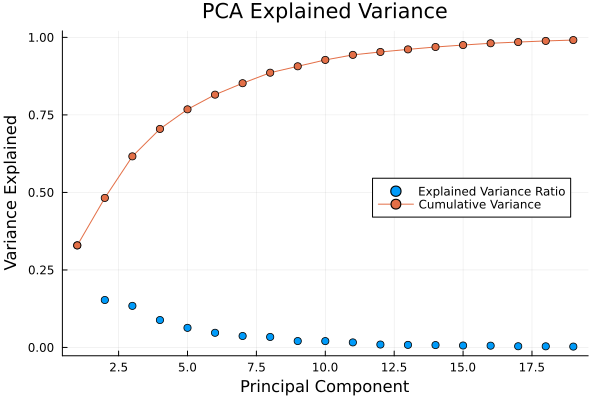

In [ ]:
function plot_pca_scree_plot(pca)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = cumsum(explained_variance_ratio)
    components = 1:length(explained_variance_ratio)


    p = plot(
        components,
        explained_variance_ratio,
        seriestype=:scatter,
        label="Explained Variance Ratio",
        xlabel="Principal Component",
        ylabel="Variance Explained",
        title="PCA Explained Variance",
        legend=:right,
        grid=true
    )

    plot!(
        components,
        cumulative_variance,
        seriestype=:line,
        label="Cumulative Variance",
        marker=:circle
    )

    display(p)
end

pca = PCA(n_components=0.99)
fit!(pca, inputs)
plot_pca_scree_plot(pca)

In [7]:
println("Variance explained by 12 components: ", sum(pca.explained_variance_ratio_[1:12]))

Variance explained by 12 components: 0.95302397


After the 12th component, the explained variance begins to level off. The total variance explained by the first 12 components is 0.95302, meaning these components account for 95% of the data's variance. This is a strong result, as it allows us to reduce the dataset's dimensionality by 65% while retaining most of the information. For cross-validation, we will set the PCA transformation's n_components parameter to achieve a 0.95 explained variance ratio. This ensures a good balance between the number of components (approximately 12, as observed) and the explained variance.

Now, before training the models, we will apply the PCA transformation to the whole data to analyze the results and try to explain a little bit about what the PCA transformation is doing to the data. In order to do so we create a heatmap, where the rows represent the original features and the columns represent the principal components. The values in the heatmap are the weights of the original features in the principal components, called the loadings. The loadings show how much each original feature contributes to each principal component.


In [ ]:
function plot_pca_loadings(pca_model)

    loadings = pca_model.components_

    num_original_features = size(loadings, 2)

    h = heatmap(loadings,
        xlabel="Original features",
        ylabel="PCA components",
        xticks=1:num_original_features,
        yticks=1:size(loadings, 1),
        color=:coolwarm,
        c=:RdBu,
        title="PCA Loadings",
        size=(800, 600)
    )

    display(h)
end

plot_pca_loadings (generic function with 1 method)

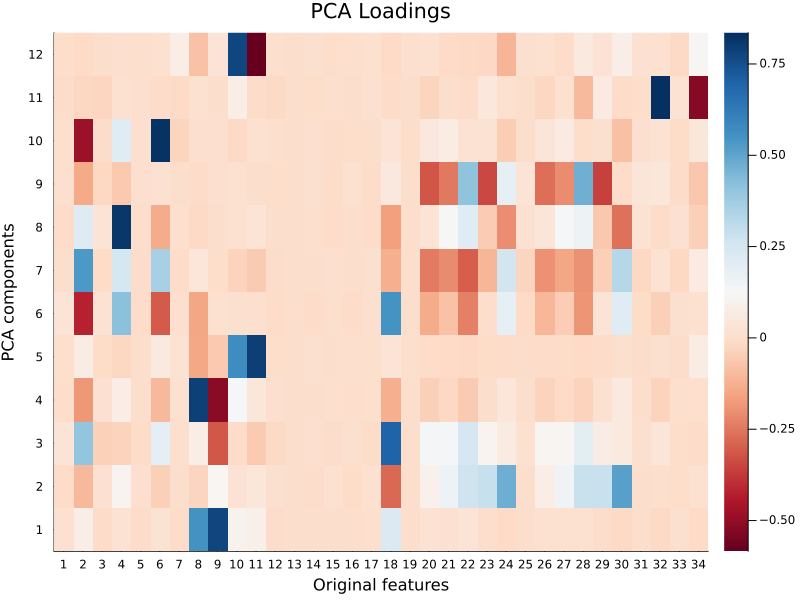

Variance explained: 0.95302397
Feature 1: Marital status
Feature 2: Application mode
Feature 3: Application order
Feature 4: Course
Feature 5: Daytime/evening attendance
Feature 6: Previous qualification
Feature 7: Nacionality
Feature 8: Mother's qualification
Feature 9: Father's qualification
Feature 10: Mother's occupation
Feature 11: Father's occupation
Feature 12: Displaced
Feature 13: Educational special needs
Feature 14: Debtor
Feature 15: Tuition fees up to date
Feature 16: Gender
Feature 17: Scholarship holder
Feature 18: Age at enrollment
Feature 19: International
Feature 20: Curricular units 1st sem (credited)
Feature 21: Curricular units 1st sem (enrolled)
Feature 22: Curricular units 1st sem (evaluations)
Feature 23: Curricular units 1st sem (approved)
Feature 24: Curricular units 1st sem (grade)
Feature 25: Curricular units 1st sem (without evaluations)
Feature 26: Curricular units 2nd sem (credited)
Feature 27: Curricular units 2nd sem (enrolled)
Feature 28: Curricular un

In [9]:
pca = PCA(n_components=0.95)
fit!(pca, inputs)
println("Variance explained: ", sum(pca.explained_variance_ratio_))
plot_pca_loadings(pca)

for (i, feature) in enumerate(names(data))
    println("Feature $i: $feature")
end

Upon examining the heatmap, several interesting observations emerge. For instance, features 8 and 9, which represent the mother's and father's qualifications, respectively, show similar weights. This is expected, as the overall qualification of the parents is likely more important than whether it is the mother’s or father’s qualification. A similar pattern is observed for features 10 and 11, which represent the mother's and father's occupations.

Another noteworthy observation is that all the features related to the curricular units (features 20 to 24 and 26 to 30) have similar weights. This suggests that the number of curricular units has a similar influence on academic performance, which we assume to be positive. Furthermore, we see a strong correlation between curricular units of the same type across two semesters, which is also expected, as the structure and content of these units are typically consistent across terms.


In [10]:
# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

### ANN

We are going to start with our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 10 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [ ]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applyPCA=true,
    pcaComponents=0.95
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.83237 ± 0.00418
	Class 1: 0.8559 ± 0.00393
	Class 2: 0.82131 ± 0.01005
	Class 3: 0.82103 ± 0.00907
Mean precision: 0.72889 ± 0.00612
	Class 1: 0.7796 ± 0.00674
	Class 2: 0.77645 ± 0.00739
	Class 3: 0.50588 ± 0.04429
Mean recall: 0.74912 ± 0.00562
	Class 1: 0.76905 ± 0.0181
	Class 2: 0.9018 ± 0.01566
	Class 3: 0.28867 ± 0.00973
Mean f1_score: 0.73109 ± 0.00408
	Class 1: 0.77412 ± 0.0082
	Class 2: 0.8344 ± 0.00997
	Class 3: 0.36668 ± 0.01465
Training ANN with topology: [32]
Mean accuracy: 0.8342 ± 0.00437
	Class 1: 0.85861 ± 0.00446
	Class 2: 0.82332 ± 0.00984
	Class 3: 0.82078 ± 0.00897
Mean precision: 0.73238 ± 0.00467
	Class 1: 0.7876 ± 0.00926
	Class 2: 0.7788 ± 0.00761
	Class 3: 0.50446 ± 0.04079
Mean recall: 0.75136 ± 0.00552
	Class 1: 0.76694 ± 0.01739
	Class 2: 0.90253 ± 0.01604
	Class 3: 0.3029 ± 0.01475
Mean f1_score: 0.73479 ± 0.00337
	Class 1: 0.77697 ± 0.00834
	Class 2: 0.83606 ± 0.0098
	Class 3: 0.3776 ± 0.01332
Training ANN

## ScikitLearn ANN

We will use the MLPClassifier from ScikitLearn to train the ANN models. The hyperparameters used in the models are the same as in the previous ANN implementation:

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [ ]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_scikit_ann = []
class_results_scikit_ann = []

for topology in topologies
  hyperparameters = Dict(
    :hidden_layer_sizes => topology,
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001,
    :repetitionsTraining => 10
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :scikit_ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applyPCA=true,
    pcaComponents=0.95
  )

  push!(general_results_scikit_ann, gr)
  push!(class_results_scikit_ann, cr)
end

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [ ]:
max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applyPCA=true,
    pcaComponents=0.95
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [ ]:
kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applyPCA=true,
    pcaComponents=0.95
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [ ]:
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        verbose=false,
        applyPCA=true,
        pcaComponents=0.95
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

### Save the results

In order to be able to compare the results of the models without running the training again, we will save the results in a dictionary. The dictionary will have the following structure:

```julia
{
    :model: {
        'num_trained_models': int,
        'parameters': Dict{String, Any},
        'general_results': [
            {
                'accuracy': AbstractVector{Float64},
                'precision': AbstractVector{Float64},
                'recall': AbstractVector{Float64},
                'f1_score': AbstractVector{Float64},
            },
            ... # One element for each trained model
        ],
        'class_results': [
            [
                {
                    'accuracy': AbstractVector{Float64},
                    'precision': AbstractVector{Float64},
                    'recall': AbstractVector{Float64},
                    'f1_score': AbstractVector{Float64},
                },
                ... # One element for each class
            ],
            ... # One element for each trained model
        ]
    }
}
```

The results of all approaches will be avaiable in the `results` dictionary. The filename with the results of individual models of this first approach will be `1_individual_results.jl`.


In [ ]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "2_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => Dict(
      "hidden_layer_sizes" => topologies
    ),
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

## Base model plots


In [7]:
results_folder = "results/"
filename = results_folder * "2_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds = aggregateMetrics(loaded_obj)
plotMetricsPerAlgorithm(loaded_obj, output_dir="./plots/Approach2", ylim=(0.6, 0.9))

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for scikit_ANN and accuracy.
Saved plots for scikit_ANN and precision.
Saved plots for scikit_ANN and recall.
Saved plots for scikit_ANN and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.


In [8]:
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach2/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.783837 │  0.670267 │ 0.682863 │ 0.662447 │
│      max_depth: 10 │ 0.772963 │  0.654976 │  0.66275 │ 0.656388 │
│      max_depth: 20 │ 0.757642 │  0.643364 │ 0.638113 │ 0.640403 │
│      max_depth: 15 │ 0.758578 │  0.640174 │ 0.639467 │ 0.639299 │
│ max_depth: nothing │ 0.752904 │   0.63977 │  0.63247 │ 0.635504 │
│       max_depth: 3 │ 0.772238 │  0.599006 │ 0.685122 │ 0.616531 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach2/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Scor

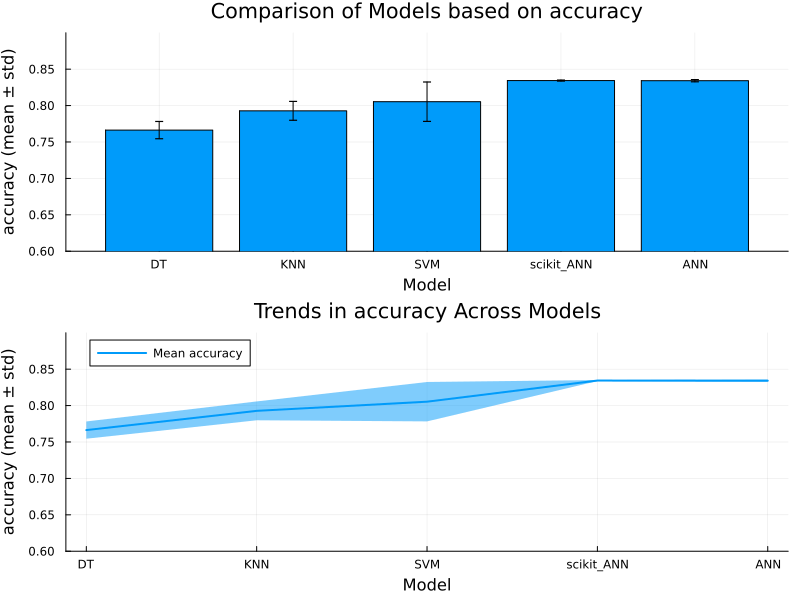

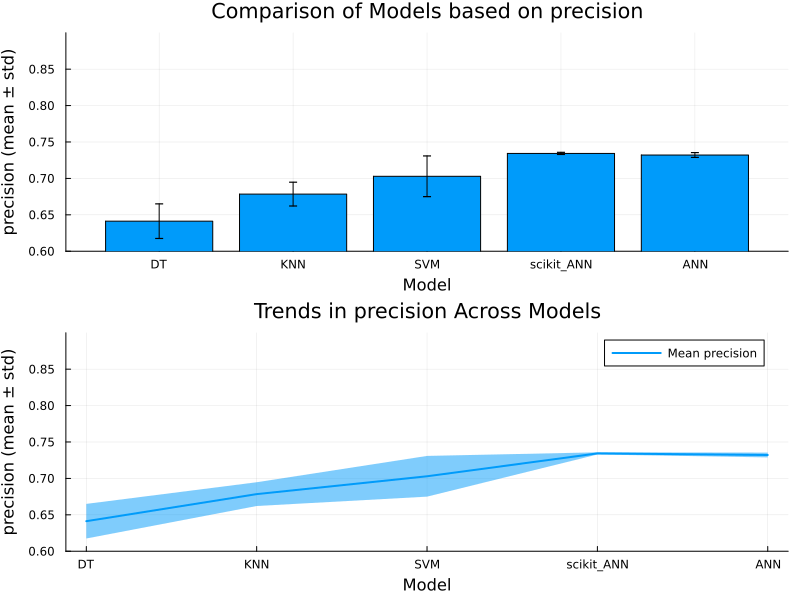

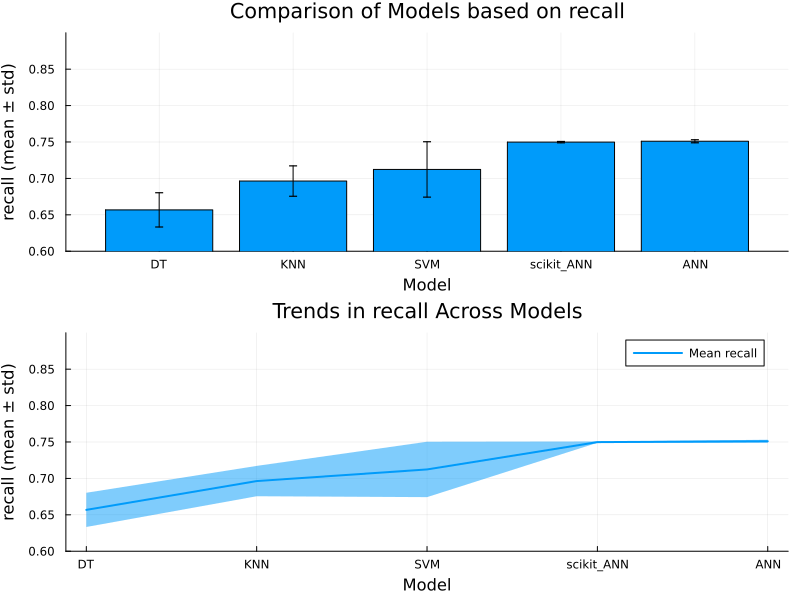

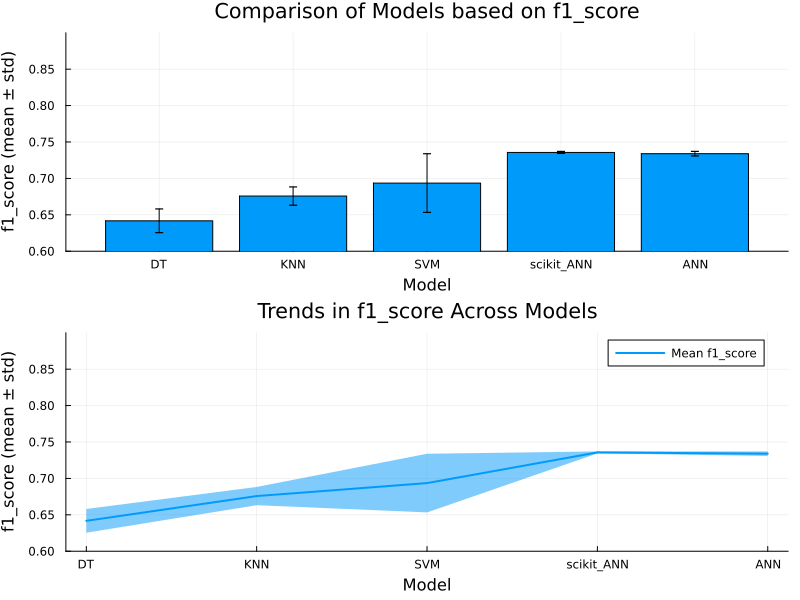

In [9]:
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots/Approach2/", show=true, ylim=(0.6, 0.9))

In [10]:
generateComparisonTable(model_names, metrics, metric_means, metric_stds; sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models (Sorted by f1_score):
┌────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│      Model │      Accuracy │     Precision │        Recall │      F1-Score │
├────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ scikit_ANN │ 0.834 ± 0.001 │ 0.734 ± 0.001 │  0.75 ± 0.001 │ 0.736 ± 0.001 │
│        ANN │ 0.834 ± 0.002 │ 0.732 ± 0.003 │ 0.751 ± 0.002 │ 0.734 ± 0.003 │
│        SVM │ 0.805 ± 0.027 │ 0.703 ± 0.028 │ 0.712 ± 0.038 │  0.694 ± 0.04 │
│        KNN │ 0.793 ± 0.013 │ 0.678 ± 0.016 │ 0.696 ± 0.021 │ 0.676 ± 0.013 │
│         DT │ 0.766 ± 0.012 │ 0.641 ± 0.024 │ 0.657 ± 0.023 │ 0.642 ± 0.016 │
└────────────┴───────────────┴───────────────┴───────────────┴───────────────┘


## Ensemble models

After training the individual models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


### Training

In [ ]:
# Select the best models
estimators = [:ANN, :SVC, :KNN]
hyperparameters = Vector{Dict}([
  Dict(
    :hidden_layer_sizes => (32),
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001
  ),
  Dict(
  :kernel => "rbf",
  :C => 1.0,
  :gamma => "auto",
  :probability => true,
  ),
  Dict(
    :n_neighbors => 11,
    :weights => "uniform",
    :metric => "euclidean",
  )])

# Define ensembles
ensembles = [
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.5, 0.2, 0.3]
    )
  ),
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.5, 0.2, 0.3]
    )
  ),
  Dict(
    :type => :Stacking,
    :hyperparameters => Dict(
      :final_estimator => LogisticRegression()
    )
  )
]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:type => :Voting, :hyperparameters => Dict{Symbol, Any}(:voting => "soft", :weights => [0.5, 0.2, 0.3]))
 Dict(:type => :Voting, :hyperparameters => Dict{Symbol, Any}(:voting => "soft", :weights => [0.5, 0.2, 0.3]))
 Dict(:type => :Stacking, :hyperparameters => Dict{Symbol, PyCall.PyObject}(:final_estimator => PyObject LogisticRegression()))

In [ ]:
for (index, ensemble) in enumerate(ensembles)
    println("Training ensemble ", ensemble[:type])
    metrics, class_results = trainClassEnsemble(
        estimators,
        hyperparameters,
        (inputs, targets_label_encoded),
        fold_indices;
        ensembleType = ensemble[:type],
        ensembleHyperParameters = ensemble[:hyperparameters],
        metricsToSave = metrics_to_save,
        verbose = false,
        repetitionsTraining = 5,
        applyPCA = true,
        pcaComponents = 0.95
    )
    ensemble[:results] = metrics
    ensemble[:class_results] = class_results
    println("------------------------------------")
end

Training ensemble Voting
Mean accuracy: 0.83703 ± 0.00579
	Class 1: 0.84357 ± 0.02395
	Class 2: 0.84206 ± 0.01537
	Class 3: 0.82794 ± 0.0072
Mean precision: 0.74161 ± 0.00715
	Class 1: 0.78748 ± 0.03462
	Class 2: 0.7942 ± 0.0237
	Class 3: 0.53867 ± 0.03465
Mean recall: 0.75678 ± 0.00884
	Class 1: 0.83071 ± 0.0989
	Class 2: 0.83565 ± 0.1185
	Class 3: 0.31053 ± 0.03379
Mean f1_score: 0.73844 ± 0.00879
	Class 1: 0.80418 ± 0.03314
	Class 2: 0.80904 ± 0.04812
	Class 3: 0.39179 ± 0.02809
------------------------------------
Training ensemble Voting
Mean accuracy: 0.83482 ± 0.00517
	Class 1: 0.83756 ± 0.02194
	Class 2: 0.8445 ± 0.01688
	Class 3: 0.82491 ± 0.00554
Mean precision: 0.73796 ± 0.00624
	Class 1: 0.78469 ± 0.03797
	Class 2: 0.79619 ± 0.02925
	Class 3: 0.52397 ± 0.02694
Mean recall: 0.75348 ± 0.0075
	Class 1: 0.84543 ± 0.09821
	Class 2: 0.81506 ± 0.10856
	Class 3: 0.30125 ± 0.01785
Mean f1_score: 0.73466 ± 0.00733
	Class 1: 0.80878 ± 0.03065
	Class 2: 0.79992 ± 0.04047
	Class 3: 0.38

In [ ]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "2_ensemble_results.jl"

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :Voting_Hard => Dict(
    "general_results" => ensembles[1][:results],
    "class_results" => ensembles[1][:class_results]
  ),
  :Voting_Soft => Dict(
    "general_results" => ensembles[2][:results],
    "class_results" => ensembles[2][:class_results]
  ),
  :Stacking => Dict(
    "general_results" => ensembles[3][:results],
    "class_results" => ensembles[3][:class_results]
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

### Ensemble model plots

In [ ]:
filename = results_folder * "2_ensemble_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds = aggregateMetrics(loaded_obj, ensemble=true)

(Any["Voting_Hard", "Voting_Soft", "Stacking"], [:accuracy, :precision, :recall, :f1_score], Dict{Symbol, Vector{Any}}(:recall => [0.7567805913010593, 0.7534822272044394, 0.758448971692311], :f1_score => [0.738443785452601, 0.7346587600974366, 0.7454592755188433], :precision => [0.7416138000701873, 0.7379606802557795, 0.7436684926272055], :accuracy => [0.8370306357446593, 0.8348181888400734, 0.8399729468694064]), Dict{Symbol, Vector{Any}}(:recall => [0.008835809801661534, 0.007495767222414446, 0.011266020775829411], :f1_score => [0.008789364958470347, 0.0073303598749102925, 0.012389306986648065], :precision => [0.00714512283630228, 0.006241824055356943, 0.011349671446378606], :accuracy => [0.005789308427087314, 0.005165360853332426, 0.007987471737060204]))

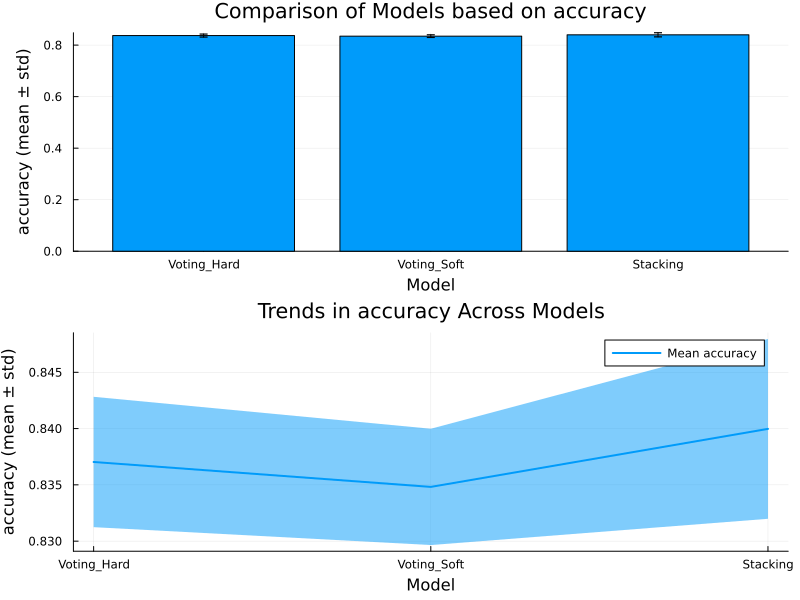

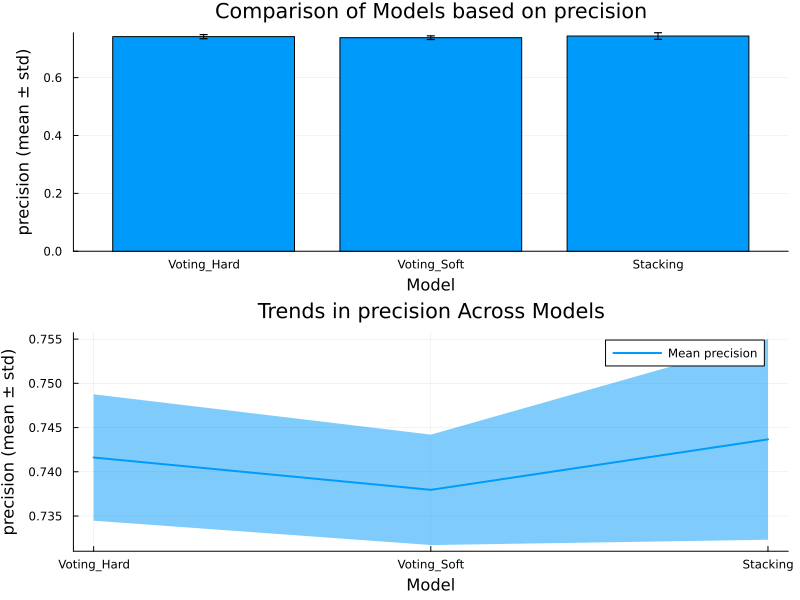

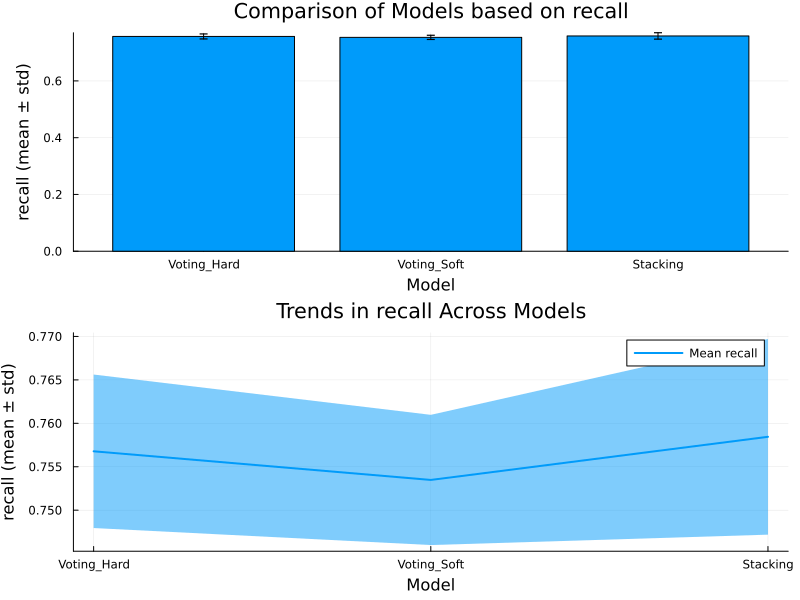

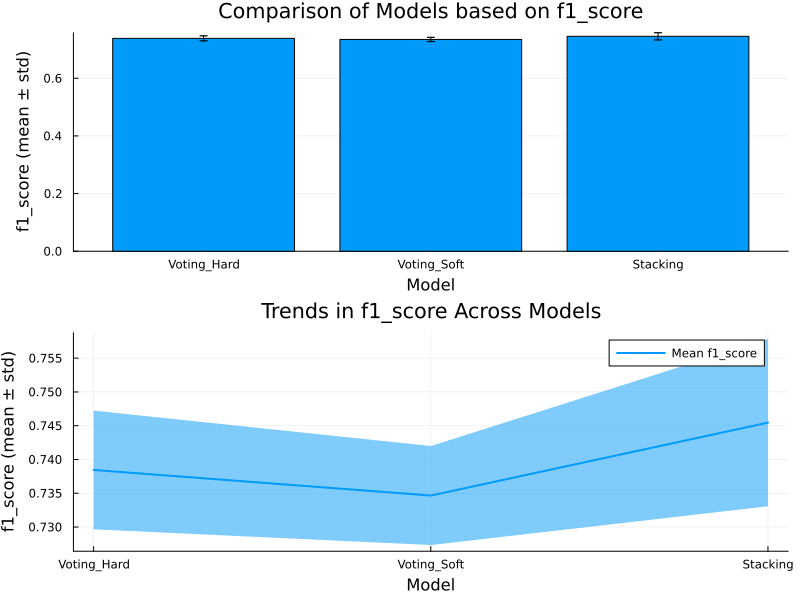

In [ ]:
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots2/ensembles", show=true)

In [ ]:
generateComparisonTable(model_names, metrics, metric_means, metric_stds; sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models (Sorted by f1_score):
┌─────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│       Model │      Accuracy │     Precision │        Recall │      F1-Score │
├─────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│    Stacking │  0.84 ± 0.008 │ 0.744 ± 0.011 │ 0.758 ± 0.011 │ 0.745 ± 0.012 │
│ Voting_Hard │ 0.837 ± 0.006 │ 0.742 ± 0.007 │ 0.757 ± 0.009 │ 0.738 ± 0.009 │
│ Voting_Soft │ 0.835 ± 0.005 │ 0.738 ± 0.006 │ 0.753 ± 0.007 │ 0.735 ± 0.007 │
└─────────────┴───────────────┴───────────────┴───────────────┴───────────────┘
